## Rate with LLM

In [35]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr

In [36]:
from langchain.schema import HumanMessage, SystemMessage
from langchain.callbacks import get_openai_callback

from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

import google.generativeai as genai

In [37]:
### Load Gemini
with open('./api_key.json', 'r') as file:
    google_api_key = json.load(file)['GeminiEduplan']
    os.environ['GOOGLE_API_KEY'] = google_api_key
    genai.configure(api_key=google_api_key)


### Load GPT
with open('./api_key.json', 'r') as file:
    openai_api_key = json.load(file)['OpenAI']
    os.environ['OPENAI_API_KEY'] = openai_api_key


### Load Claude
with open('./api_key.json', 'r') as file:
    claude3haiku_api_key = json.load(file)['Claude']
    os.environ['ANTHROPIC_API_KEY'] = claude3haiku_api_key

In [38]:
# for model in genai.list_models():
#     print(model.name)

In [39]:
m0 = pd.read_csv("./mohler_dataset_edited.csv")
display(m0.head())

,id,question,desired_answer,student_answer,score_me,score_other,score_avg
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0


In [40]:
system_prompt = """
You are an automated grader specialized in evaluating student responses. You follow a grading scale from 0 to 1.  

General Grading Scale:  
1. **Score = 1.0**: All **essential concepts** (EC) are present and clearly explained, no major errors, and the answer is complete.  
2. **Score of 0.8-0.9**: The ECs are present, but the answer has slight inaccuracies or minor omissions.  
3. **Score of 0.6-0.7**: Some ECs are missing or ambiguously formulated, showing general understanding but incompleteness.  
4. **Score of 0.3-0.5**: The answer is partial or unclear, with several ECs missing or poorly addressed.  
5. **Score of 0.1-0.2**: Largely off-topic or very incomplete, with only a small correct element.  
6. **Score = 0**: No answer or entirely off-topic.  

You may apply **bonuses** for clarity, precision, or mentioning additional important concepts and **penalties** for serious confusion or contradictions.  

At the end, you must **assign a score from 0 to 1** based on the grading scale.
"""

In [41]:
user_prompt_template = """
User (or Instruction)  
Task:  
1. Read the **question** posed to the student.  
2. Review the **expected answer** (i.e., the reference solution).  
3. Examine the **student's response**.  
4. Assign a grade (a floating-point number between 0 and 1) according to the **rules** and **grading tiers** above.  

### Elements to Evaluate  
- Presence of **essential concepts** (mention them if possible)  
- Accuracy and clarity of the formulation  
- Any confusion or errors  
- The relevance of any secondary concepts (bonus or penalty)  

### Example Input Format  
<in>  
    {example_input} 
</in>  

### Expected Final Output Format  
<out>  
    {example_output} 
</out>  

Ensure that the expected response is enclosed between <out></out> and is a dictionary where the keys follow the format `"student x grade"`, where `"x"` is the student's number and the value is the grade you gave to him. Do not add any additional comments to the output. Only return:  
<out> [YOUR RESPONSE HERE] </out>  

Here is the current input:  
<in>  
{current_input}
</in>  
"""

In [42]:
example_input ="""
    Student 1:  
    - **Question**: [What is the role of a prototype program in problem solving?]  
    - **Expected answer**: [To address major issues in the creation of the program. There is no way to account for all possible bugs in the program, but it is possible to prove the program is tangible.]  
    - **Student's response**: [To simulate the behaviour of portions of the desired software product.]  

    Student 2:  
    - **Question**: [What is a pointer?]
    - **Expected answer**: [The address of a location in memory.] 
    - **Student's response**: [A pointer is a variable that points to the address location of another variable.  Represented by (*).]"""

In [43]:
example_output = """{"etudiant 1 grade": 0.5, "etudiant 2 grade": 1}"""

In [44]:
llm_gpt = ChatOpenAI(model_name="gpt-4o", temperature=0) # Ou gpt-4 si vous avez accès
llm_gemini = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0) # Pour Gemini
llm_anthropic = ChatAnthropic(model_name="claude-3-5-sonnet-20241022", temperature=0)#claude-3-5-sonnet-latest

In [45]:
etudiants = []
expected_scores = []
counter = 0
for i in range(m0.shape[0]):
    # if m0.loc[i, "desired_answer"].find("#NAME?") != -1 or m0.loc[i, "student_answer"].find("#NAME?") != -1:
    #     continue
    etudiants.append(f"""
    Etudiant {i+1}:
    - **Question** : [{m0.loc[i, "question"]}]
    - **Réponse attendue** : [{m0.loc[i, "desired_answer"]}]
    - **Réponse de l’étudiant** : [{m0.loc[i, "student_answer"]}]
    """)
    expected_scores.append(m0.loc[i, 'score_avg'])
    counter += 1

In [46]:
prompts = []
scores_groups = []
messages_group = []
for i in range(0, len(etudiants), 10):
    candidates = "\n".join(etudiants[i:i+10])
    user_prompt = user_prompt_template.format(example_input=example_input, example_output=example_output, current_input=candidates)
    messages_group.append([SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)])
    
    # Extraire et traiter le résultat pour cet étudiant
    scores_groups.append(expected_scores[i:i+10])
    prompts.append(user_prompt)

In [1]:
import pickle

In [2]:
run = False
if run == True:
    responses_claude = {}
    counter = 0
    for messages in (messages_group):
        counter += 1
        responses_claude[counter] = llm_anthropic.invoke(messages_group[counter - 1])
    with open("mohler_claude_grade.pkl", "wb") as file:
        pickle.dump(responses_claude, file)
else:
    with open("mohler_claude_grade.pkl", "rb") as file:
        responses_claude = pickle.load(file)

In [3]:
run = False
if run == True:
    responses_gpt = {}
    counter = 0
    for messages in (messages_group):
        counter += 1
        responses_gpt[counter] = llm_gpt.invoke(messages_group[counter - 1])
    with open("mohler_gpt_grade.pkl", "wb") as file:
        pickle.dump(responses_gpt, file)
else:
    with open("mohler_gpt_grade.pkl", "rb") as file:
        responses_gpt = pickle.load(file)

In [4]:
run = False
if run == True:
    responses_gemini = {}
    counter = 0
    for messages in (messages_group):
        counter += 1
        responses_gemini[counter] = llm_gemini.invoke(messages_group[counter - 1])
    with open("mohler_gemini_grade.pkl", "wb") as file:
        pickle.dump(responses_gemini, file)
else:
    with open("mohler_gemini_grade.pkl", "rb") as file:
        responses_gemini = pickle.load(file)

In [53]:
import re

def extract_number(text):
    match_obj = re.search(r'\d+', text)
    return int(match_obj.group()) if match_obj else None

def extract_brace_content(text):
    match_obj = re.search(r'\{(.*?)\}', text)
    if match_obj != None:
        return "{%s}"%(match_obj.group(1)) if match_obj else None
    else:
        start_pos = text.find("{")
        end_pos = text.find("}")
        if not (-1 in [start_pos, end_pos]):
            return text[start_pos:end_pos+1]
        return None

In [54]:
def extract_grades(data:list):
    llm_scores = []
    students_llm_scores = {}
    failed_index = []

    for i in range(len(data)):
        try:
            response_text = data[i+1].content
            for string in ['```json', '```', '<out>', '</out>', '\\']:
                response_text = response_text.replace(string, '')
                
            response_text = extract_brace_content(response_text)
            response_dict = json.loads(response_text)

            temp_scores = []
            for key in sorted(response_dict.keys()):
                student_id = extract_number(key)
                students_llm_scores[student_id] = response_dict[key]
                temp_scores.append(response_dict[key])
            llm_scores.append(temp_scores)
        except:
            failed_index.append(i+1)
        
    return {
        "llm_score": llm_scores.copy(),
        "students_llm_score": students_llm_scores.copy(),
        "failed_indexes": failed_index.copy()
    }


In [55]:

models_responses = {"gpt":responses_gpt, "claude":responses_claude, "gemini": responses_gemini} 
models_students_scores = {}
for model_name in models_responses:
    out_data = extract_grades(models_responses[model_name])
    llm_scores = out_data['llm_score']
    students_llm_scores:dict = out_data['students_llm_score']
    failed_indexes = out_data['failed_indexes']

    if model_name == "gpt":
        for index in {9, 38, 67, 96, 125, 154, 183, 694, 1025}: 
            # llm_scores.insert(index-1, 0)
            students_llm_scores[index] = 0

    print(f"\n----- Model: {model_name} -----\n")
    print(f"Failed indexes : [", *failed_indexes, "]")
    if not model_name == "gpt": print(f"Correlation 1: ", pearsonr(np.concatenate(llm_scores), np.concatenate(scores_groups)))

    students_ids, students_scores =  zip(*sorted(students_llm_scores.items(), key=lambda item: item[0]))
    models_students_scores[model_name] = np.array(students_scores)
    print(f"Correlation 2: ", pearsonr(students_scores, np.concatenate(scores_groups)))
    



----- Model: gpt -----

Failed indexes : [ ]
Correlation 2:  PearsonRResult(statistic=0.8000099549034733, pvalue=0.0)

----- Model: claude -----

Failed indexes : [ ]
Correlation 1:  PearsonRResult(statistic=0.7911385083484902, pvalue=0.0)
Correlation 2:  PearsonRResult(statistic=0.8068425736545104, pvalue=0.0)

----- Model: gemini -----

Failed indexes : [ ]
Correlation 1:  PearsonRResult(statistic=0.745609714974479, pvalue=0.0)
Correlation 2:  PearsonRResult(statistic=0.7596418361588506, pvalue=0.0)


In [56]:
def rmse(y_pred, y_true):
    return np.sqrt(np.nanmean((y_true - y_pred) ** 2))

### Score directly with score

In [57]:
def linear_projection(x, scale=5):
    #scale is the projection factor
    return np.round(scale*x, 2)

def exponential_projection(x, scale=5, p=2):
    #scale is the projection factor
    #p is the controling parameter of the non linearity
    return np.round(scale*(x**p), 2) 

def logarithmic_projection(x, scale = 5, ampli=10):
    #scale is the projection factor
    #ampli is the amplification factor
    return np.round((scale*np.log(1+ampli*x))/np.log(1+ampli))

def sigmoid_projection(x, scale=5, mean = 0.5, slope=6):
    #scale is the projection factor
    #mean is the controlling parameter around which mean value should be amplified
    #slope is the controlling parameter of the slope
    return np.round(scale / (1 + np.exp(-slope*(x - mean))))


GPT - RMSE:


min Linear Projection : repetition=1 rmse=1.1642910208235138
min Exponential Projection : power=0.4 rmse=0.7083412739045791
min Logarithmic Projection : amplification=15.0 rmse=0.7448588270533761
min Sigmoid Projection : slope=4.0 rmse=0.721837048199316


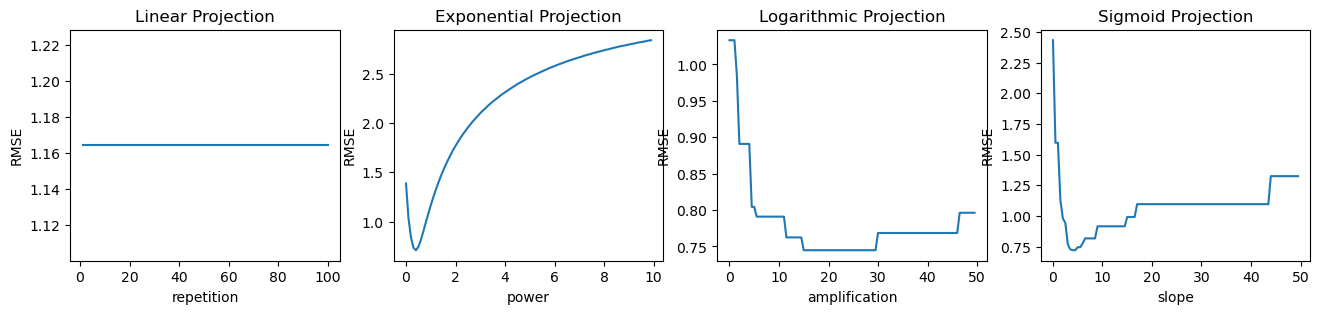


CLAUDE - RMSE:
min Linear Projection : repetition=1 rmse=1.0409760872634344
min Exponential Projection : power=0.4 rmse=0.7259290359561124
min Logarithmic Projection : amplification=15.0 rmse=0.7689800324879419
min Sigmoid Projection : slope=4.0 rmse=0.7224462738264847


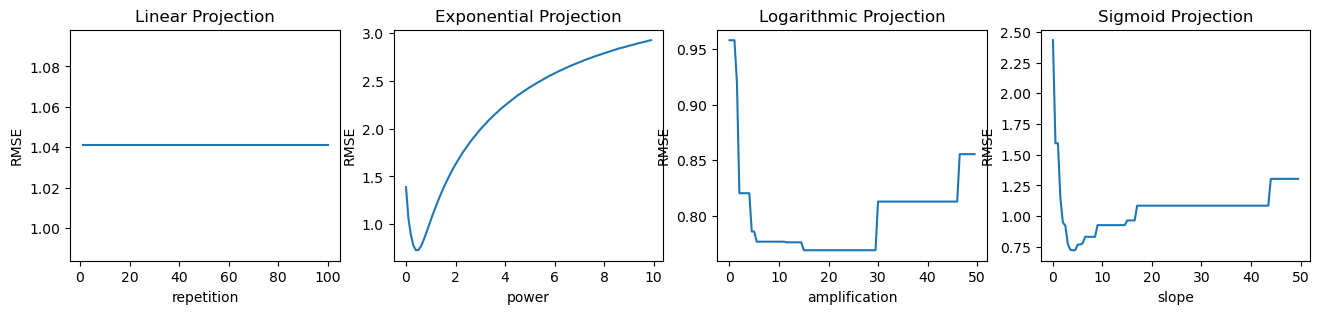


GEMINI - RMSE:
min Linear Projection : repetition=1 rmse=1.073691255645917
min Exponential Projection : power=0.5 rmse=0.8284949037521805
min Logarithmic Projection : amplification=11.5 rmse=0.8738247087633781
min Sigmoid Projection : slope=3.0 rmse=0.7889591594077442


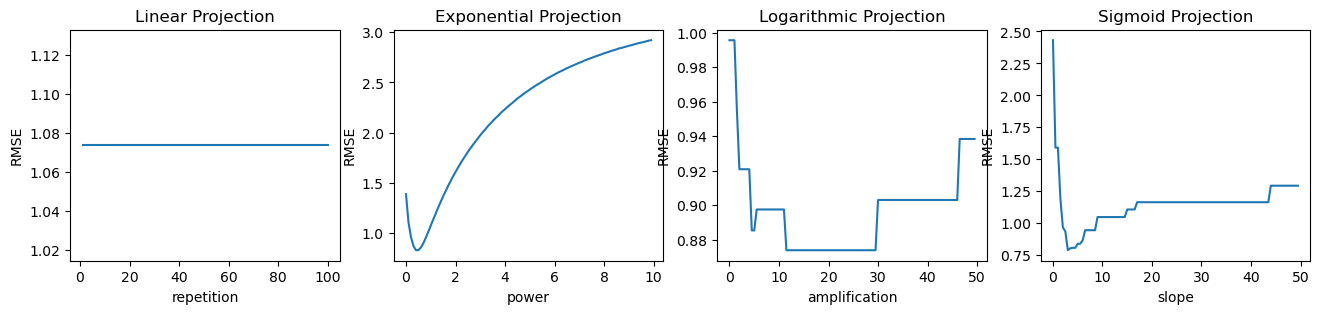

In [58]:
for model_name in models_students_scores:
    students_scores_numpy = np.array(models_students_scores[model_name])
    plt.figure(figsize=(16, 3))
    print(f"\n{model_name.upper()} - RMSE:")
    x_rmses = [
        [
            'linear projection',
            'repetition',
            range(1, 101),
            [rmse(linear_projection(students_scores_numpy), np.concatenate(scores_groups))]*100
        ],
        [
            'exponential projection',
            'power',
            np.arange(0, 10, 0.1),
            [rmse(exponential_projection(students_scores_numpy, p=p_itr), np.concatenate(scores_groups)) for p_itr in np.arange(0, 10, 0.1)]
        ],
        [ 
            'logarithmic projection',
            'amplification',
            np.arange(0, 50, 0.5),
            [rmse(logarithmic_projection(students_scores_numpy, ampli=ampli_itr + 0.001), np.concatenate(scores_groups)) for ampli_itr in np.arange(0, 50, 0.5)]
        ],
        [   
            'sigmoid projection',
            'slope',
            np.arange(0, 50, 0.5),
            [rmse(sigmoid_projection(students_scores_numpy, mean=0.25, slope=slope_itr), np.concatenate(scores_groups)) for slope_itr in np.arange(0, 50, 0.5)]
        ]
    ]

    for i  in range(4):
        plt.subplot(1, 4, i+1)
        plt.plot(x_rmses[i][2], x_rmses[i][3])
        plt.xlabel(x_rmses[i][1])
        plt.ylabel('rmse'.upper())
        # plt.ylim(0.6, 1.3)
        plt.title(x_rmses[i][0].title())
        print(f"min {x_rmses[i][0].title()} : "+"{}={} rmse={}".format(x_rmses[i][1], *list(sorted(zip(x_rmses[i][2], x_rmses[i][3]), key= lambda item: item[1]))[0]))
    plt.show()
    

In [59]:
print("Correlation 1" , pearsonr(exponential_projection(students_scores_numpy, p=0.4), np.concatenate(scores_groups)))
print("Correlation 2" , pearsonr(sigmoid_projection(students_scores_numpy, mean=0.25, slope=4), np.concatenate(scores_groups)))

Correlation 1 PearsonRResult(statistic=0.721547500866651, pvalue=0.0)
Correlation 2 PearsonRResult(statistic=0.7367724055264814, pvalue=0.0)


Methodologie et resultats
On utilise un LLM pour grader les reponses des etudiants sur une echele de 0 a 1 avec des paliers dont les criteres d'evaluations sont fournis a partir d'un prompt.

Une fois les grades obtenu la premiere idee serait de faire une projection lineaire  avec une pente de 5. Toutefois nous pouvons egalement envisager d'autres types de projections comme une projection de puissance (exponential projection), une projection logarithmique avec amplification et une projection sigmoidale. Chacun aillant ses propres caracteristiques.

- L'approche lineaire $y = 5x$: Simple a mettre en oeuvre mais ps de raffinement ;
- L'approche exponentielle $y = 5x^p$: Amplifie les scores eleves, utile son veux "recommpenser" les meilleurs ;
- L'approche logarithmique $ y = 5 \frac{log(1+kx)}{log(1+k)}$: Comprime les faibles scores et amplifie legerement les forts scores; 
- L'approche sigmoide $y=\frac{5}{1 + e^{-k(x-0.5)}}$: Lissage, utile pour une separation pas trop brutale scores faibles - scores forts.

D'apres les resultats ci-dessous nous observons que le model claude performent en general mieux que les autres et affiches des performances en terme de RMSE qui battent l'etat de l'art avec une projection de puissance = 0.4 et sigmoide de pente = 4 pour des RMSE respectives de 0.7259 et 0.7224.

### Gaussian smoothing and linear interpolation

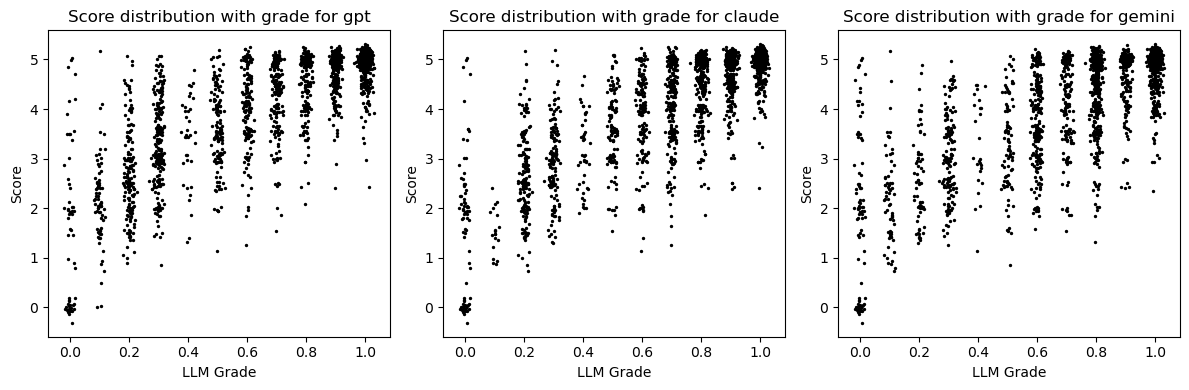

In [60]:
plt.figure(figsize=(12, 4))
# Add noise to increase visibility
noise_grade = np.random.normal(0, 0.01, len(models_students_scores['claude']))  # Noise for students_scores
noise_score = np.random.normal(0, 0.1, len(m0['score_avg']))  # Noise for m0['score_avg']

for index, model_name in enumerate(models_students_scores):
    plt.subplot(1, 3, index+1)
    plt.scatter(models_students_scores[model_name] + noise_grade, m0['score_avg'] + noise_score, c='black', s=2)
    plt.title(f'Score distribution with grade for {model_name}')
    plt.xlabel('LLM Grade')
    plt.ylabel('Score')

# Displaying
plt.tight_layout()
plt.show()


In [61]:
i_set = m0['id'].unique()

Distribution of scores per question with GPT


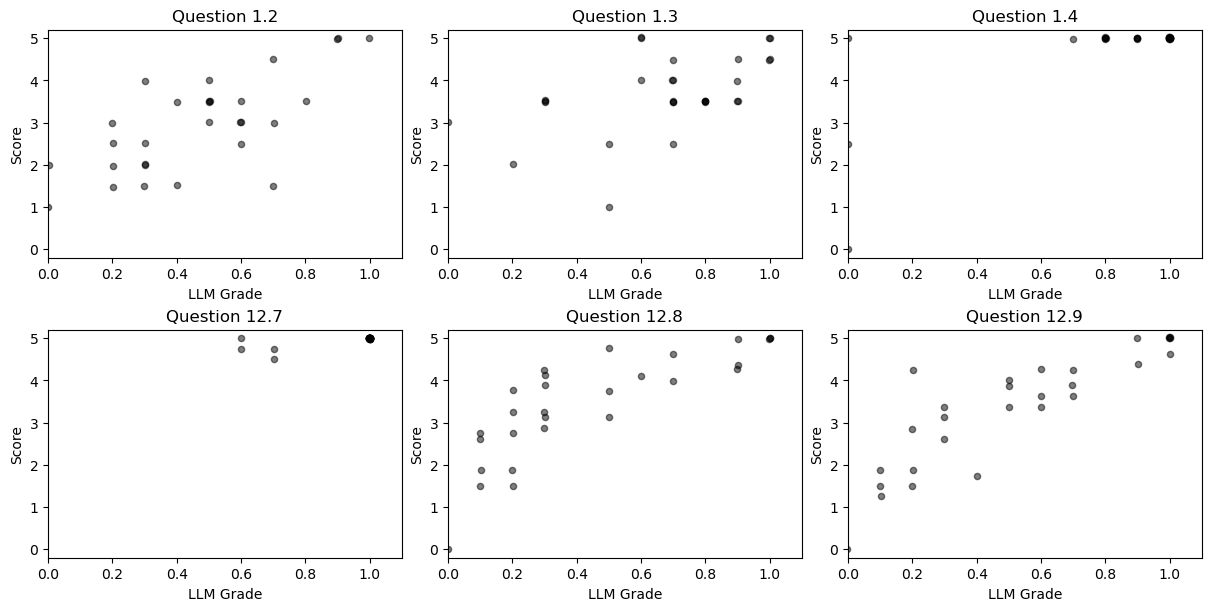


Distribution of scores per question with CLAUDE


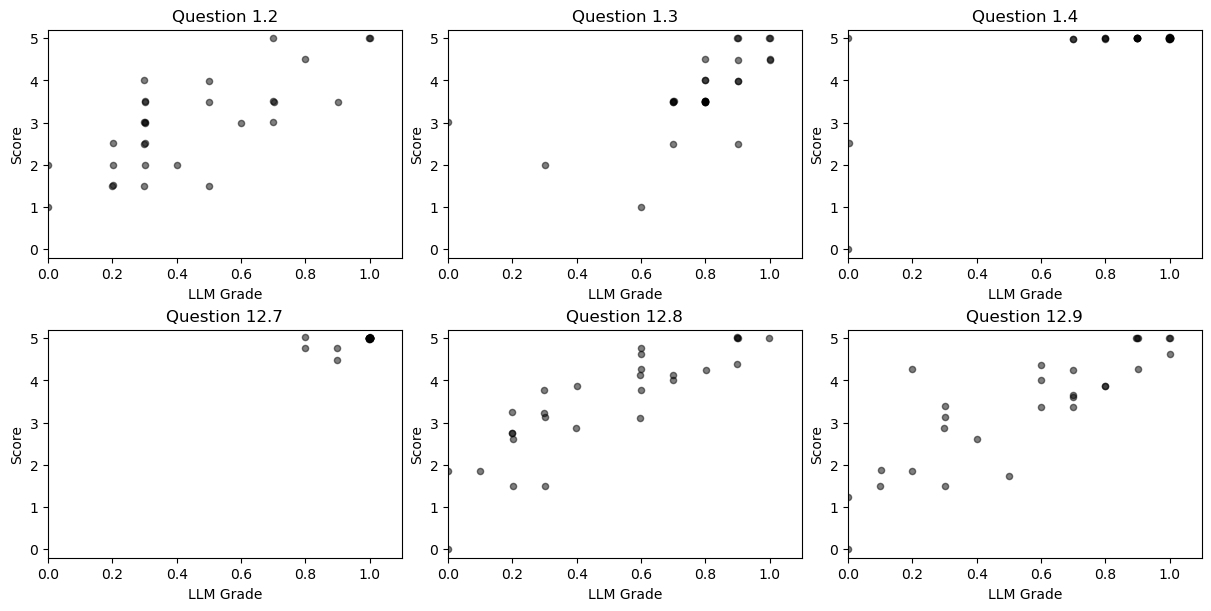


Distribution of scores per question with GEMINI


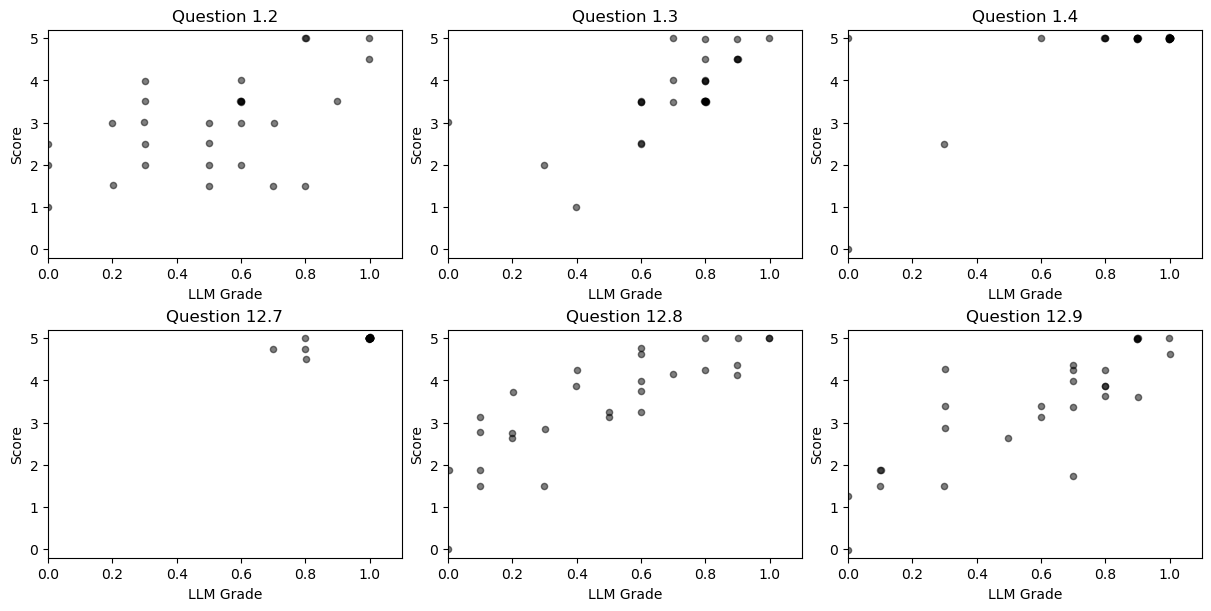

In [62]:
for model_name in models_students_scores:
    print(f"Distribution of scores per question with {model_name.upper()}")
    fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)

    for ax, question_id in zip(axes.flatten(), i_set[[1, 2, 3 , 77, 78, 79]]):
        mask = m0['id'] == question_id
        ax.scatter(models_students_scores[model_name][mask] + np.random.normal(0, 0.001, mask.sum()),
                m0.loc[mask, 'score_avg'] + np.random.normal(0, 0.01, mask.sum()),
                s=20, marker='o', color='black', alpha=0.5)
        ax.set_title(f"Question {question_id}")
        ax.set_xlabel("LLM Grade")
        ax.set_ylabel("Score")
        ax.set_xlim(0, 1.10)
        ax.set_ylim(-.20, 5.20)
        # ax.grid(True)
    plt.show()
    print()



Scores prediction with GPT


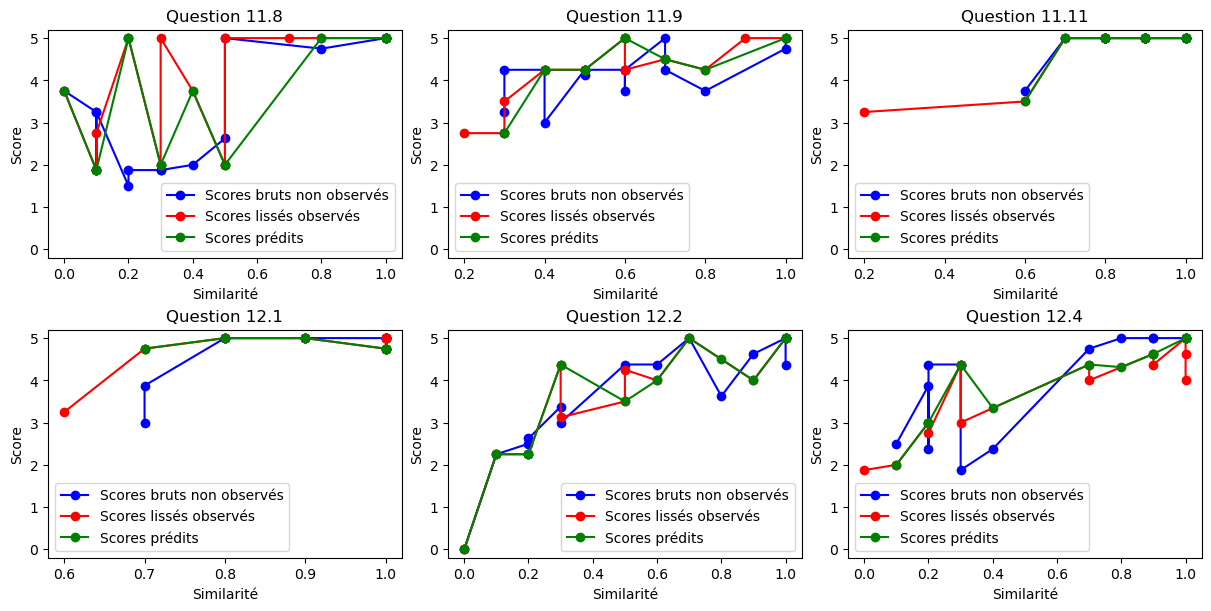

[0.3437238936408715, 0.4197650572907661, 1.0, 0.24714351385927316, 0.9017905405557289, 0.6467771160563092]

Scores prediction with CLAUDE


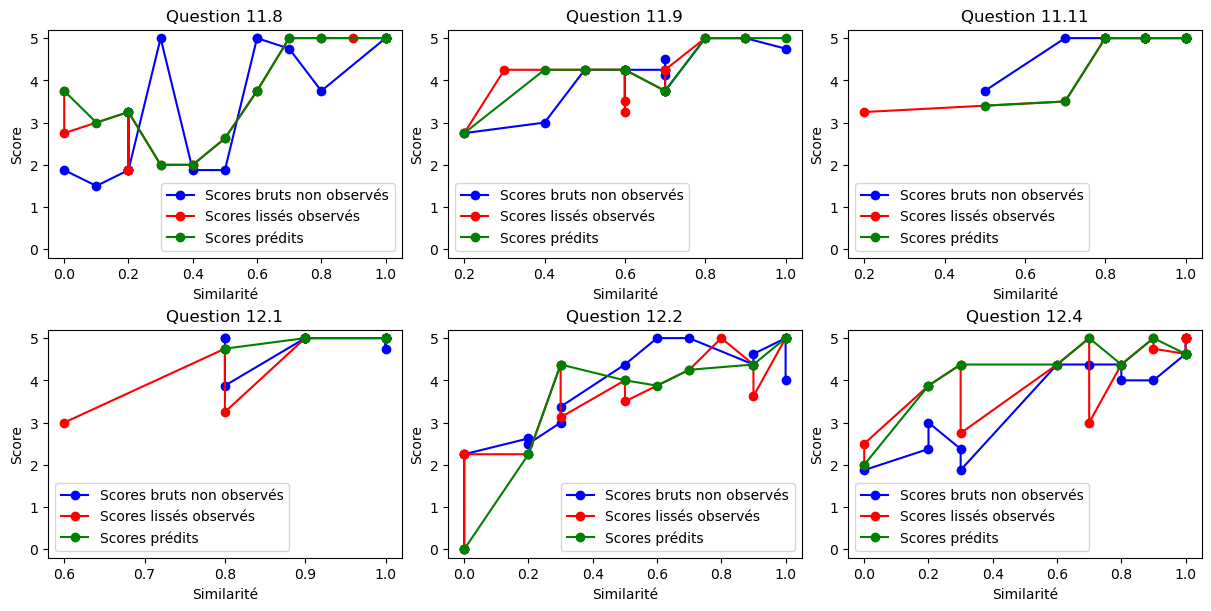

[0.5602128074674972, 0.7502082971243266, 0.7063229697834591, 0.49515038494298713, 0.8461815843198951, 0.6354836499406717]

Scores prediction with GEMINI


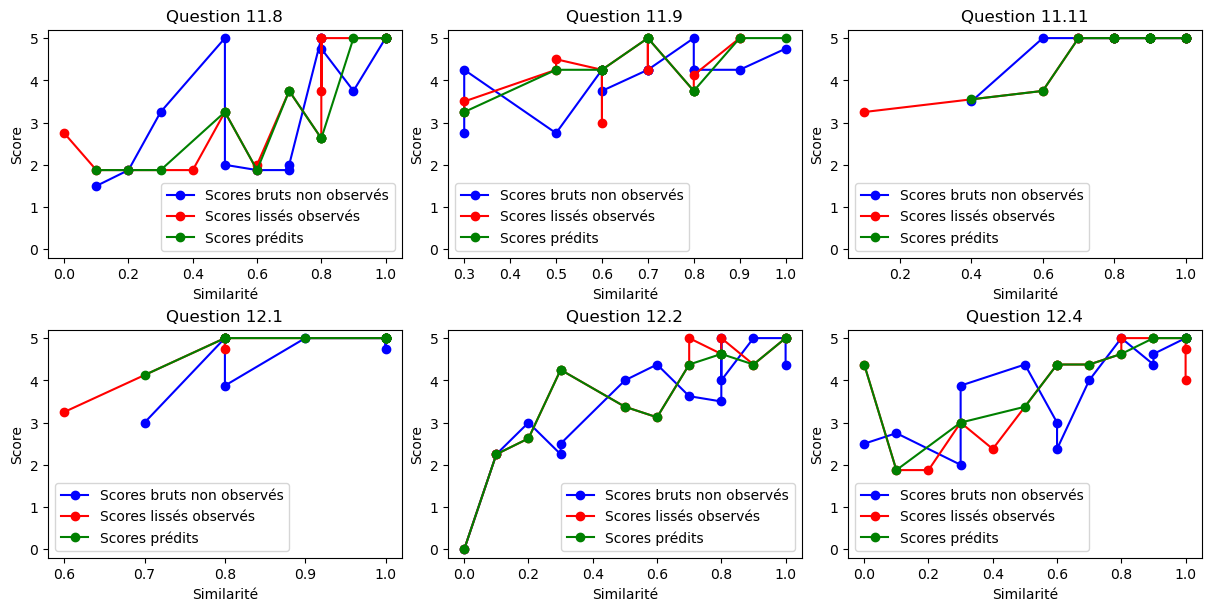

[0.4470280423331149, 0.28529863306222575, 0.7372929287622193, 0.8590833238192478, 0.7739464092875036, 0.5688885487813288]


In [63]:
for model_name in models_students_scores:
    print(f"\nScores prediction with {model_name.upper()}") 
    # Étape 1 : Créer m1 en supprimant la colonne 'desired_answer' et en ajoutant res0
    m1 = m0.drop(columns=['desired_answer'])  # Supprimer 'desired_answer'
    m1.insert(m1.columns.get_loc('question'), 'res0', models_students_scores[model_name])  # Ajouter 'res0' avant 'question'

    q = m1['id'].unique()  # Identifiants uniques des questions

    # Étape 3 : Configurer la disposition pour les graphiques
    fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)

    # Définir la fenêtre pour le lissage
    window = 0.4  # Cette valeur sera utilisée plus tard dans les calculs

    # Étape 1 : Définir l'intervalle des questions à traiter
    res = []
    for ax, q_i in zip(axes.flatten(), range(69, 75)):  # R: 70 à 75 inclus
        # Filtrer les données pour la question actuelle
        df = m1[m1['id'] == q[q_i]].sort_values('res0')[['res0', 'score_avg']]

        # Étape 2 : Diviser les données en deux groupes (observé et non observé)
        indices = np.arange(len(df))
        i = indices % 2 == 0  # Lignes paires comme observées

        # Étape 3 : Appliquer le lissage sur les scores observés
        observed_res0 = df.loc[i, 'res0'].values+1e-9
        observed_scores = df.loc[i, 'score_avg'].values
        smoothed_scores = observed_scores#gaussian_filter(observed_scores, sigma=window)

        # Étape 4 : Tracer les données
        ax.plot(df.loc[~i, 'res0'], df.loc[~i, 'score_avg'], 'o-', color='blue', label='Scores bruts non observés')
        ax.plot(observed_res0, smoothed_scores, 'o-', color='red', label='Scores lissés observés')

        # Étape 5 : Interpoler pour les scores non observés
        predicted_scores  = np.interp(df.loc[~i, 'res0'].values, observed_res0, smoothed_scores)
        # predicted_scores = interpolation(d+np.random.normal(0, 0.01, df.loc[~i, 'res0'].values.shape[0]))

        # Ajouter les scores prédits au graphique
        ax.plot(df.loc[~i, 'res0'], predicted_scores, 'o-', color='green', label='Scores prédits')
        ax.set_ylim(-0.2, 5.2)
        ax.set_title(f'Question {q[q_i]}')
        ax.set_xlabel('Similarité')
        ax.set_ylabel('Score')
        ax.legend()

        # Étape 6 : Calculer la corrélation entre les scores prédits et les scores réels non observés
        corr = np.corrcoef(predicted_scores, df.loc[~i, 'score_avg'].values)[0, 1]
        res.append(corr)

    plt.show()
    # Final score
    print(res)


In [72]:
windows = {'gpt': 1.2, 'claude':1.1, 'gemini': 2.2}
for model_name in models_students_scores:
    print(f"\nCorrelation evaluation with {model_name}")

    # Étape 1 : Créer m1 en supprimant la colonne 'desired_answer' et en ajoutant res0
    m1 = m0.drop(columns=['desired_answer'])  # Supprimer 'desired_answer'
    m1.insert(m1.columns.get_loc('question'), 'res0', models_students_scores[model_name])  # Ajouter 'res0' avant 'question'

    q = m1['id'].unique()  # Identifiants uniques des questions

    # Étape 2 : Calculer les prédictions et collecter les résultats
    res = []
    for quest in q:
        # Filtrer les données pour la question actuelle
        df = m1[m1['id'] == quest].sort_values('res0')[['res0', 'score_avg']]

        # Diviser les données en observés et non observés
        indices = np.arange(len(df))
        i = indices % 2 == 0  # Observés : indices pairs

        # Lissage des scores observés
        observed_res0 = df.loc[i, 'res0'].values
        observed_scores = df.loc[i, 'score_avg'].values
        smoothed_scores = gaussian_filter(observed_scores, sigma=windows[model_name])

        # Interpolation pour prédire les scores non observés
        predicted_scores = np.interp(df.loc[~i, 'res0'].values, observed_res0, smoothed_scores)
        
        # Stocker les résultats
        res.append({
            'pred': predicted_scores,
            'observed': df.loc[~i, 'score_avg'].values,
            'q': np.repeat(quest, len(predicted_scores)),
            'i': np.where(~i)[0]
        })

    # Étape 3 : Extraire les scores prédits et observés
    res_pred = np.concatenate([r['pred'] for r in res])
    res_observed = np.concatenate([r['observed'] for r in res])

    # Résultats finaux
    # print("Scores prédits :", res_pred)
    # print("Scores observés :", res_observed)

    # Calcul de la corrélation entre les scores prédits et observés
    correlation, _ = pearsonr(res_pred, res_observed)

    print(f"Corrélation entre les scores prédits et observés : {correlation:.3f}")



Correlation evaluation with gpt


Corrélation entre les scores prédits et observés : 0.826

Correlation evaluation with claude
Corrélation entre les scores prédits et observés : 0.815

Correlation evaluation with gemini
Corrélation entre les scores prédits et observés : 0.777


In [65]:

for model_name in models_students_scores:
    print(f"\nCalcul de l'erreur avec {model_name}")
    # Étape 1 : Créer m1 en supprimant la colonne 'desired_answer' et en ajoutant res0
    m1 = m0.drop(columns=['desired_answer'])  # Supprimer 'desired_answer'
    m1.insert(m1.columns.get_loc('question'), 'res0', models_students_scores[model_name])  # Ajouter 'res0' avant 'question'

    q = m1['id'].unique()  # Identifiants uniques des questions

    # Étape 1 : Initialiser les résultats pour chaque fenêtre
    window_values = np.arange(0.1, 4.1, 0.1)  # Équivalent de seq(.1, 2, .1)
    res3 = []

    for window in window_values:
        # Étape 2 : Calculer le RMSE pour chaque question
        rmse_per_question = []
        for q_i in range(len(q)):
            # Filtrer les données pour la question actuelle
            df = m1[m1['id'] == q[q_i]].sort_values('res0')[['res0', 'score_avg']]

            # Diviser les données en observées et non observées
            indices = np.arange(len(df))
            i = indices % 2 == 0  # Observées : indices pairs

            # Lissage des scores observés
            observed_res0 = df.loc[i, 'res0'].values
            observed_scores = df.loc[i, 'score_avg'].values
            smoothed_scores = gaussian_filter(observed_scores, sigma=window)

            # Interpolation pour les scores non observés
            
            predicted_scores = np.interp(df.loc[~i, 'res0'].values, observed_res0, smoothed_scores)

            actual_scores = df.loc[~i, 'score_avg'].values
            # Calculer le RMSE pour cette question
            rmse_v = rmse(predicted_scores, actual_scores)
            rmse_per_question.append(rmse_v)

        # Stocker les RMSE pour toutes les questions pour cette fenêtre
        res3.append(rmse_per_question)

    # Étape 3 : Convertir en matrice numpy
    res3 = np.array(res3)

    # Étape 4 : Calculer les moyennes des RMSE pour chaque fenêtre
    mean_rmse_per_window = res3.mean(axis=1)

    # Étape 5 : Associer les fenêtres et leurs RMSE moyens
    result = np.vstack((window_values, mean_rmse_per_window))

    display(pd.DataFrame(data=[['Valeurs des fenêtres (window)', *result[0]], ['RMSE moyens', *result[1]]]))

    # Trouver la fenêtre avec le plus faible RMSE
    optimal_window = window_values[np.argmin(mean_rmse_per_window)]
    print(f"Fenêtre optimale : {optimal_window:.1f}")
    print(f"RMSE Min: {np.min(result[1])}")



Calcul de l'erreur avec gpt


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.300000,0.4000,0.50000,0.600000,0.700000,0.800000,0.900000,...,3.100000,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.00000
1,RMSE moyens,0.653239,0.653237,0.651149,0.6323,0.60337,0.583031,0.571571,0.564994,0.561072,...,0.591927,0.594692,0.597536,0.600473,0.603486,0.606578,0.609764,0.613016,0.616355,0.61976


Fenêtre optimale : 1.2
RMSE Min: 0.5575935433261883

Calcul de l'erreur avec claude


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,...,3.100000,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.000000
1,RMSE moyens,0.659565,0.659563,0.657385,0.637695,0.607586,0.587376,0.577336,0.572528,0.570159,...,0.593419,0.595634,0.597932,0.600329,0.602805,0.605364,0.608016,0.610738,0.613549,0.616427


Fenêtre optimale : 1.1
RMSE Min: 0.5687368288578535

Calcul de l'erreur avec gemini


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,...,3.100000,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.000000
1,RMSE moyens,0.731499,0.731498,0.729559,0.712529,0.687784,0.671702,0.663184,0.658074,0.654356,...,0.642299,0.643705,0.645218,0.646841,0.648564,0.650385,0.652308,0.654318,0.656425,0.658614


Fenêtre optimale : 2.2
RMSE Min: 0.6357426475758312


In [66]:
def choosen_index(size: int, number_of_items_to_select=15):
    return np.isin(
        np.arange(size), 
        np.random.choice(size, size=number_of_items_to_select, replace=False)
    )

### 15 Choisies aleatoirement

In [67]:

for model_name in models_students_scores:
    print(f"\nCalcul de l'erreur avec {model_name}")
    # Étape 1 : Créer m1 en supprimant la colonne 'desired_answer' et en ajoutant res0
    m1 = m0.drop(columns=['desired_answer'])  # Supprimer 'desired_answer'
    m1.insert(m1.columns.get_loc('question'), 'res0', models_students_scores[model_name])  # Ajouter 'res0' avant 'question'

    q = m1['id'].unique()  # Identifiants uniques des questions

    # Étape 1 : Initialiser les résultats pour chaque fenêtre
    window_values = np.arange(0.1, 4.1, 0.1)  # Équivalent de seq(.1, 2, .1)
    res3 = []
    res4 = []

    for window in window_values:
        # Étape 2 : Calculer le RMSE pour chaque question
        rmse_per_question = []
        correlation_per_question = []
        for q_i in range(len(q)):
            # Filtrer les données pour la question actuelle
            df = m1[m1['id'] == q[q_i]].sort_values('res0')[['res0', 'score_avg']]

            # Diviser les données en observées et non observées
            i = choosen_index(len(df), 15)

            # Lissage des scores observés
            observed_res0 = df.loc[i, 'res0'].values
            observed_scores = df.loc[i, 'score_avg'].values
            smoothed_scores = gaussian_filter(observed_scores, sigma=window)

            # Interpolation pour les scores non observés
            predicted_scores = np.interp(df.loc[~i, 'res0'].values , observed_res0, smoothed_scores)
            
            actual_scores = df.loc[~i, 'score_avg'].values 
            # Calcul de la corrélation entre les scores prédits et observés
            # correlation, _ = pearsonr(actual_scores, actual_scores)
            # correlation_per_question.append(correlation)

            # Calculer le RMSE pour cette question
            rmse_ve = rmse(predicted_scores, actual_scores)
            rmse_per_question.append(rmse_ve)

        # Stocker les RMSE pour toutes les questions pour cette fenêtre
        res3.append(rmse_per_question)
        res4.append(correlation_per_question)

    # Étape 3 : Convertir en matrice numpy
    res3 = np.array(res3)
    res4 = np.array(res4)

    # Étape 4 : Calculer les moyennes des RMSE pour chaque fenêtre
    mean_rmse_per_window = res3.mean(axis=1)

    # mean_correlation_per_window = res4.mean(axis=1)

    # Étape 5 : Associer les fenêtres et leurs RMSE moyens
    result = np.vstack((window_values, mean_rmse_per_window))

    display(pd.DataFrame(data=[['Valeurs des fenêtres (window)', *result[0]], ['RMSE moyens', *result[1]]]))

    # Trouver la fenêtre avec le plus faible RMSE
    optimal_window = window_values[np.argmin(mean_rmse_per_window)]
    # corres_correlation = mean_correlation_per_window[np.argmin(mean_rmse_per_window)]
    print(f"Fenêtre optimale : {optimal_window:.1f}")
    # print(f"Correlation : {corres_correlation:.1f}")
    print(f"RMSE Min: {np.min(result[1])}")



Calcul de l'erreur avec gpt


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,...,3.100000,3.200000,3.30000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.000000
1,RMSE moyens,0.723179,0.667475,0.703256,0.683576,0.697729,0.654572,0.615287,0.651991,0.604773,...,0.721289,0.697534,0.68273,0.671644,0.690345,0.670316,0.645351,0.699595,0.678218,0.696082


Fenêtre optimale : 2.0
RMSE Min: 0.5914895898551289

Calcul de l'erreur avec claude


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.30000,0.400000,0.500000,0.600000,0.70000,0.800000,0.900000,...,3.10000,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.000000
1,RMSE moyens,0.702847,0.736988,0.71354,0.703327,0.700026,0.633907,0.62417,0.650738,0.653435,...,0.66793,0.649289,0.667108,0.685258,0.640201,0.676098,0.691401,0.711557,0.676522,0.720372


Fenêtre optimale : 1.8
RMSE Min: 0.5887713350074727

Calcul de l'erreur avec gemini


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,...,3.100000,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.000000
1,RMSE moyens,0.770562,0.788768,0.788373,0.777926,0.730915,0.672358,0.710988,0.713594,0.727862,...,0.677389,0.704481,0.708218,0.704658,0.706345,0.730966,0.729285,0.769095,0.731398,0.699842


Fenêtre optimale : 1.7
RMSE Min: 0.6514700706311216


### Leave one out

In [73]:
windows = {'gpt':0.4, 'claude':3.2, 'gemini':3.2}
for model_name in models_students_scores:
    print(f"\nCorrelation evaluation with {model_name}")

    # Étape 1 : Créer m1 en supprimant la colonne 'desired_answer' et en ajoutant res0
    m1 = m0.drop(columns=['desired_answer'])  # Supprimer 'desired_answer'
    m1.insert(m1.columns.get_loc('question'), 'res0', models_students_scores[model_name])  # Ajouter 'res0' avant 'question'

    q = m1['id'].unique()  # Identifiants uniques des questions

    # Étape 2 : Calculer les prédictions et collecter les résultats
    res = []
    for quest in q:
        # Filtrer les données pour la question actuelle
        df = m1[m1['id'] == quest].sort_values('res0')[['res0', 'score_avg']]

        # Diviser les données en observés et non observés
        i = choosen_index(len(df), len(df)-15)

        # Lissage des scores observés
        observed_res0 = df.loc[i, 'res0'].values
        observed_scores = df.loc[i, 'score_avg'].values
        smoothed_scores = gaussian_filter(observed_scores, sigma=windows[model_name])

        # Interpolation pour prédire les scores non observés
        predicted_scores = np.interp(df.loc[~i, 'res0'].values, observed_res0, smoothed_scores)
        
        # Stocker les résultats
        res.append({
            'pred': predicted_scores,
            'observed': df.loc[~i, 'score_avg'].values,
            'q': np.repeat(quest, len(predicted_scores)),
            'i': np.where(~i)[0]
        })

    # Étape 3 : Extraire les scores prédits et observés
    res_pred = np.concatenate([r['pred'] for r in res])
    res_observed = np.concatenate([r['observed'] for r in res])

    # Calcul de la corrélation entre les scores prédits et observés
    correlation, _ = pearsonr(res_pred, res_observed)

    print(f"Corrélation entre les scores prédits et observés : {correlation:.3f}")



Correlation evaluation with gpt
Corrélation entre les scores prédits et observés : 0.733

Correlation evaluation with claude
Corrélation entre les scores prédits et observés : 0.745

Correlation evaluation with gemini
Corrélation entre les scores prédits et observés : 0.712


In [69]:

for model_name in models_students_scores:
    print(f"\nCalcul de l'erreur avec {model_name}")
    # Étape 1 : Créer m1 en supprimant la colonne 'desired_answer' et en ajoutant res0
    m1 = m0.drop(columns=['desired_answer'])  # Supprimer 'desired_answer'
    m1.insert(m1.columns.get_loc('question'), 'res0', models_students_scores[model_name])  # Ajouter 'res0' avant 'question'

    q = m1['id'].unique()  # Identifiants uniques des questions

    # Étape 1 : Initialiser les résultats pour chaque fenêtre
    window_values = np.arange(0.1, 4.1, 0.1)  # Équivalent de seq(.1, 2, .1)
    res3 = []
    res4 = []

    for window in window_values:
        # Étape 2 : Calculer le RMSE pour chaque question
        rmse_per_question = []
        correlation_per_question = []
        for q_i in range(len(q)):
            # Filtrer les données pour la question actuelle
            df = m1[m1['id'] == q[q_i]].sort_values('res0')[['res0', 'score_avg']]

            # Diviser les données en observées et non observées
            i = choosen_index(len(df), len(df)-1)

            # Lissage des scores observés
            observed_res0 = df.loc[i, 'res0'].values
            observed_scores = df.loc[i, 'score_avg'].values
            smoothed_scores = gaussian_filter(observed_scores, sigma=window)

            # Interpolation pour les scores non observés
            predicted_scores = np.interp(df.loc[~i, 'res0'].values, observed_res0, smoothed_scores)
            # predicted_scores = interpolation(df.loc[~i, 'res0'].values)

            # Calculer le RMSE pour cette question
            actual_scores = df.loc[~i, 'score_avg'].values
            rmse = np.sqrt(np.mean((predicted_scores - actual_scores) ** 2))
            rmse_per_question.append(rmse)
            # Calcul de la corrélation entre les scores prédits et observés
            # correlation, _ = pearsonr(predicted_scores, actual_scores)
            # correlation_per_question.append(correlation)

        # Stocker les RMSE pour toutes les questions pour cette fenêtre
        res3.append(rmse_per_question)
        # res4.append(correlation_per_question)

    # Étape 3 : Convertir en matrice numpy
    res3 = np.array(res3)
    res4 = np.array(res4)

    # Étape 4 : Calculer les moyennes des RMSE pour chaque fenêtre
    mean_rmse_per_window = res3.mean(axis=1)

    # mean_correlation_per_window = res4.mean(axis=1)

    # Étape 5 : Associer les fenêtres et leurs RMSE moyens
    result = np.vstack((window_values, mean_rmse_per_window))

    display(pd.DataFrame(data=[['Valeurs des fenêtres (window)', *result[0]], ['RMSE moyens', *result[1]]]))

    # Trouver la fenêtre avec le plus faible RMSE
    optimal_window = window_values[np.argmin(mean_rmse_per_window)]
    # corres_correlation = mean_correlation_per_window[np.argmin(mean_rmse_per_window)]
    print(f"Fenêtre optimale : {optimal_window:.1f}")
    # print(f"Correlation : {corres_correlation:.1f}")
    print(f"RMSE Min: {np.min(result[1])}")



Calcul de l'erreur avec gpt


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.300000,0.400000,0.50000,0.600000,0.700000,0.800000,0.900000,...,3.10,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.000000
1,RMSE moyens,0.421296,0.472221,0.322716,0.269839,0.34122,0.507551,0.361892,0.320716,0.419463,...,0.39,0.463625,0.444606,0.413515,0.373841,0.350587,0.461302,0.399221,0.384316,0.458109


Fenêtre optimale : 0.4
RMSE Min: 0.2698385836606256

Calcul de l'erreur avec claude


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.10000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.90000,...,3.100000,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.00000
1,RMSE moyens,0.39249,0.403549,0.345414,0.534362,0.430317,0.357802,0.473114,0.440082,0.39578,...,0.514432,0.324136,0.526934,0.390107,0.385669,0.390229,0.384655,0.464639,0.506454,0.35982


Fenêtre optimale : 3.2
RMSE Min: 0.3241361445648181

Calcul de l'erreur avec gemini


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Valeurs des fenêtres (window),0.100000,0.200000,0.30000,0.400000,0.500000,0.600000,0.70000,0.80000,0.900000,...,3.100000,3.200000,3.300000,3.400000,3.500000,3.600000,3.700000,3.800000,3.900000,4.000000
1,RMSE moyens,0.572531,0.461419,0.44611,0.501369,0.367433,0.361295,0.52467,0.58988,0.553517,...,0.445371,0.318992,0.561239,0.423064,0.391233,0.562072,0.423323,0.506812,0.373601,0.402026


Fenêtre optimale : 3.2
RMSE Min: 0.3189923690268833
